# DATA ANALYSIS COUNT

Colouring the embedding space based on the frequency of locations in sequences. 


In [1]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap
import numpy as np
import csv
import matplotlib.pyplot as plt


In [2]:
# model=word2vec.Word2Vec.load('../Data/Models/word2vec_epoch_1000_min_1.model')
#model=word2vec.Word2Vec.load('../Data/Models/best_model.model')
model=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/best_model_100_dim_5e.model')

In [3]:
with open('../Data/sequences.csv', 'r') as f:
    reader = csv.reader(f)
    sequences = list(reader)

In [4]:
X = model.wv.vectors

In [5]:
# tsne
def tsne_plot(X):
    X=np.array(X)
    #pca = PCA(n_components=50)
    #X_pca=pca.fit_transform(X)
    proj = TSNE(perplexity=20).fit_transform(X)
    return proj
proj=tsne_plot(X)

# UMAP 
proj_1 = umap.UMAP(n_components=2, n_neighbors=20, metric='cosine').fit_transform(X)

# pca 
pca = PCA(n_components=2)
proj_2=pca.fit_transform(X)

In [6]:
# pacmap 
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_3 = embedding.fit_transform(X, init="pca")


In [7]:
# Create a dictionary to map addresses to their corresponding embeddings
journey_embeddings = {}
for journey in sequences:
    for place in journey:
        try:
            journey_id = place  # Convert the journey list to a tuple to use as a dictionary key
            journey_embeddings[journey_id] = model.wv[journey_id]
        except KeyError:
            # Handle cases where the journey is not present in the Word2Vec model
            pass

# Convert dictionary to numpy array
X = np.array(list(journey_embeddings.values()))

# Create a list of all addresses
journey_ids = list(journey_embeddings.keys())



# Create a dictionary mapping addresses to their index in the numpy array
journey_idx = {journey_id: idx for idx, journey_id in enumerate(journey_ids)}

In [8]:
print(len(journey_ids)) #number of unique locations is 3751

3751



____________________________________________________________________________________________________________________________________________________



















# Plots with count

In [9]:
counts_to_labels = {100: '0-100', 1000: '101-1000', 5000: '1001-5000', 10000: '5001-10000', 50000: '10000-50000', 100000: '50001-100000', 1000001: '100000+'}


In [10]:
address_count_seq = {}
for seq in sequences:
    for place in seq:
        if place in address_count_seq:
            address_count_seq[place] += 1
        else:
            address_count_seq[place] = 1


from collections import Counter

# Count occurrences of each number of mentions of addresses. So counting how many addresses was mentioned once and so on
address_counts = Counter(address_count_seq.values())

# Sort the counts by their keys (number of mentions), in descending order
sorted_counts = sorted(address_counts.items(), key=lambda x: x[0], reverse=True)

In [11]:

address_cluster_count = {}

for address in address_count_seq.keys():
      count = address_count_seq[address]
      if 0 <= count <= 100:
         address_cluster_count[address] = 100
      elif 101 <= count <= 1000:
         address_cluster_count[address] = 1000
      elif 1001 <= count <= 5000:
         address_cluster_count[address] = 5000
      elif 5001 <= count <= 10000:
         address_cluster_count[address] = 10000
      elif 10001 <= count <= 50000:
         address_cluster_count[address] = 50000
      elif 50001 <= count <= 100000:
         address_cluster_count[address] = 100000
      elif 100001 <= count:
         address_cluster_count[address] = 1000001
      else:
         print("address was: ", address)
         address_cluster_count[address] = 0 


In [12]:
from collections import Counter

# Count occurrences of each zip code
count_counts = Counter(address_cluster_count.values())

# Print the zip code counts
for occurrence, count in sorted(count_counts.items()):
    print(f"Count {occurrence}: {count} occurrences")

Count 100: 4063 occurrences
Count 1000: 833 occurrences
Count 5000: 265 occurrences
Count 10000: 57 occurrences
Count 50000: 76 occurrences
Count 100000: 22 occurrences
Count 1000001: 9 occurrences


{100: '#ffe119', 1000: '#f58231', 5000: '#3cb44b', 10000: '#42d4f4', 50000: '#4363d8', 100000: '#f032e6', 1000001: '#e6194b'}


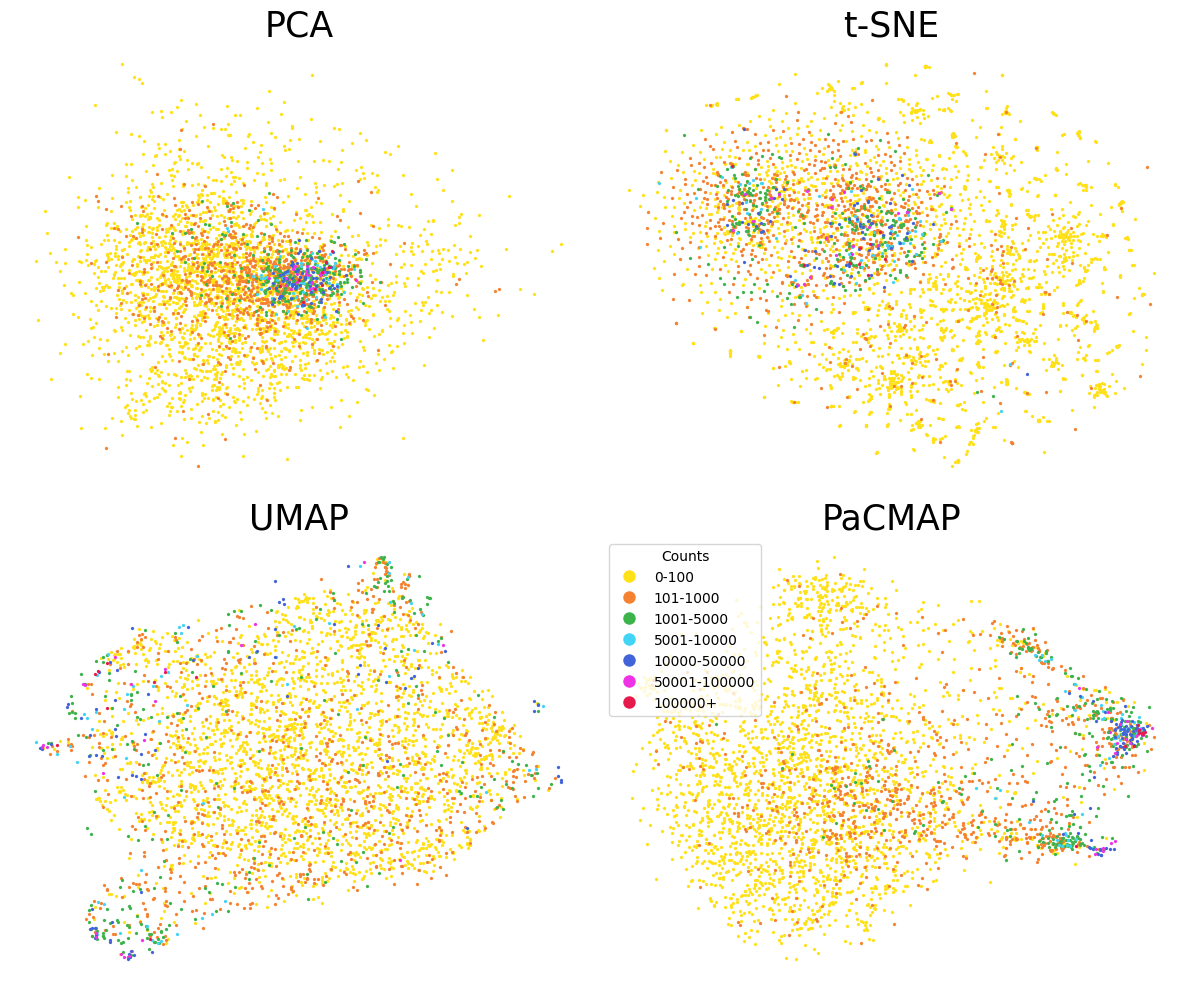

In [13]:

# Define color palette for zip codes
count_colors = {}  # Dictionary to map zip codes to colors
unique_count_codes = sorted(counts_to_labels.keys())
num_colors = len(unique_count_codes) #change this
#color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
color_palette = ['#ffe119', '#f58231', '#3cb44b', '#42d4f4', '#4363d8', '#f032e6', '#e6194b']
#print("number of unique zips: ", num_colors)

for idx, count_code in enumerate(unique_count_codes):
    count_colors[count_code] = color_palette[idx]

print(count_colors)
# Create the plots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
xs = [proj_2, proj, proj_1, proj_3]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0

for row in ax:
    for col in row:
        col.set_title(ts[s], fontsize=25)

        for current_count_code in unique_count_codes:
            relevant_addresses = []
            for address, count_code in address_cluster_count.items():
                if address in journey_ids:
                    if current_count_code == count_code:
                        relevant_addresses.append(address)

            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, label=current_count_code, c=count_colors[current_count_code]
            )
        #  # Add labels to stations makes it impossible to read 
        #     for journey_id in relevant_journeys_zip:
        #         x_coord = xs[s][journey_idx[journey_id]][0]
        #         y_coord = xs[s][journey_idx[journey_id]][1]
        #         col.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed
            
        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=count_colors[count_code], label=counts_to_labels[count_code]) for count_code in unique_count_codes]
plt.legend(handles=handles, title='Counts')

fig.tight_layout()
plt.show()
